In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('src/')


import numpy as np
import matplotlib.pyplot as plt


from loguru import logger

from WADParser import open_wad_file
from WADViewer import WadViewer
from WADPlayer import MIDIPlayer
from mus2mid import Mus2Mid

In [3]:
w = open_wad_file('WADs/DOOM.WAD')

2025-03-30 20:44:30.191 | INFO     | WADParser:__init__:41 - Found a DOOM IWAD.
2025-03-30 20:44:30.191 | INFO     | WADParser:_get_palette:116 - Palette extracted.
2025-03-30 20:44:30.201 | INFO     | WADParser:_parse_levels:156 - Found 36 level(s) in this WAD.
2025-03-30 20:44:30.213 | INFO     | WADParser:_parse_things:128 - DOOM THINGS loaded.
2025-03-30 20:44:30.323 | INFO     | WADParser:_parse_by_markers:186 - 107 FLATS found in this WAD.
2025-03-30 20:44:30.324 | INFO     | WADParser:_parse_by_markers:186 - 764 SPRITES found in this WAD.
2025-03-30 20:44:30.350 | INFO     | WADParser:_gather_textures:352 - Found 287 textures in 2 texture lumps.
2025-03-30 20:44:30.353 | INFO     | WADParser:_gather_musics:364 - Found 32 music lumps.


In [ ]:
w.save_mus('D_E1M3')

2025-03-30 20:44:37.018 | INFO     | WADParser:save_mus:378 - Saved music D_E1M3 to output/D_E1M3.mus.


In [6]:
m2m = Mus2Mid('output/D_E1M3.mus')
m2m.to_midi('output/D_E1M3.mid')


2025-03-30 20:44:45.024 | INFO     | mus2mid:__init__:70 - File format: b'MUS\x1a'
2025-03-30 20:44:45.042 | INFO     | mus2mid:mus2mid:217 - Track size written: 30033 vs 19246
2025-03-30 20:44:45.043 | INFO     | mus2mid:to_midi:223 - Exported MUS output/D_E1M3.mus as a MIDI file to output/D_E1M3.mid.


In [7]:
player = MIDIPlayer('output/D_E1M3.mid')


In [ ]:
player.play()

In [9]:
viewer = WadViewer(w)

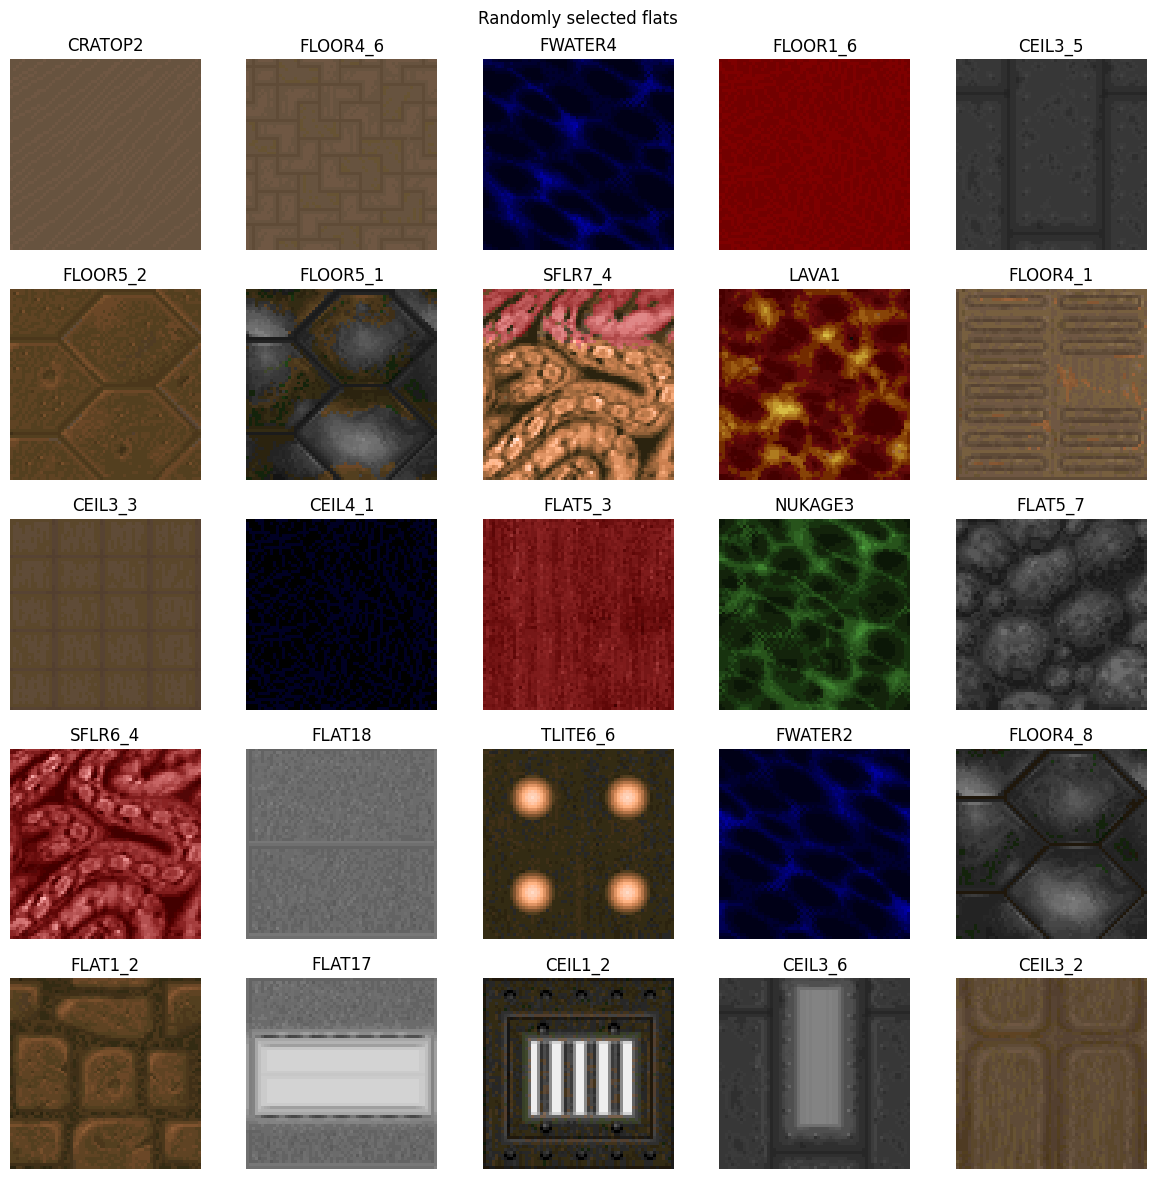

In [10]:
n_flats = 25
fig, ax = plt.subplots(5, 5, figsize=(12, 12))
ax = ax.ravel()

all_flat_names = list(w.flats.keys())
selected_flats = np.random.choice(all_flat_names, size=n_flats, replace=False)

for i, flat_name in enumerate(selected_flats):

    viewer.draw_flat(flat_name, ax=ax[i])
    ax[i].set_title(flat_name)
    ax[i].axis('off')

fig.suptitle('Randomly selected flats')
fig.tight_layout(pad=1.2)

2025-03-30 20:45:33.657 | INFO     | WADViewer:draw_map:88 - Plotted map E3M6.


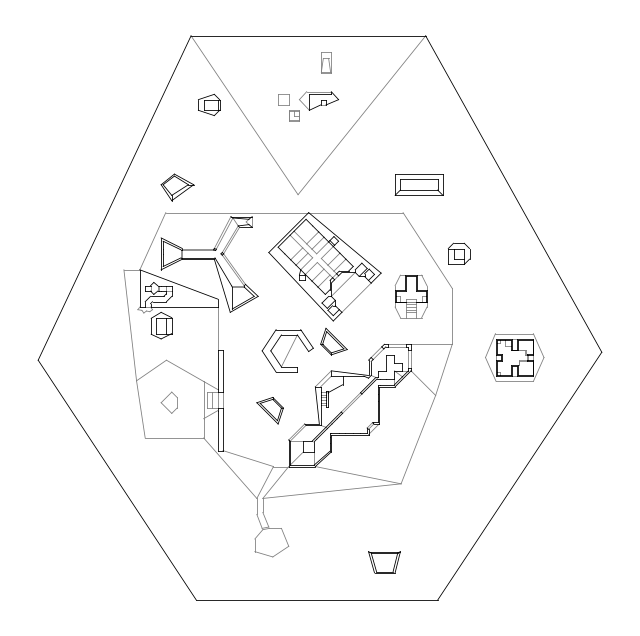

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
viewer.draw_map('E3M6', palette='OMGIFOL', ax=ax)

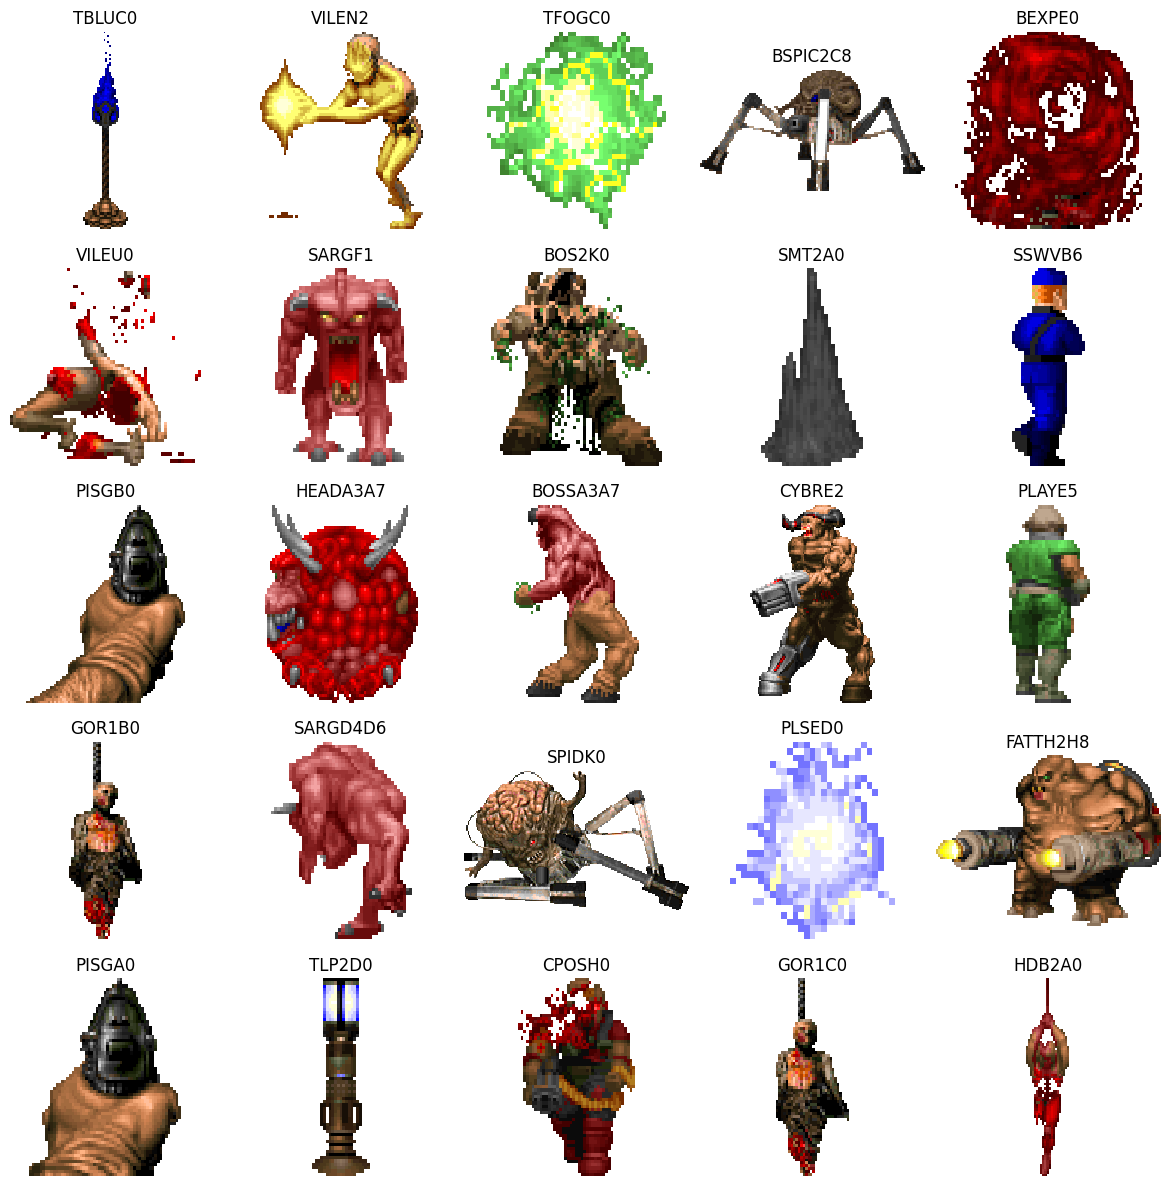

In [6]:
n_sprites = 25
fig, ax = plt.subplots(5, 5, figsize=(12, 12))
ax = ax.ravel()

all_sprite_names = list(w.sprites.keys())
selected_sprites = np.random.choice(all_sprite_names, size=n_sprites, replace=False)

for i, sprite_name in enumerate(selected_sprites):

    rgb_image = w.draw_patch(*w.sprites[sprite_name])

    # Original DOOM had non-square pixels!
    ax[i].imshow(rgb_image / 255, aspect=1.2, interpolation='nearest') 
    ax[i].set_title(sprite_name)
    ax[i].axis('off')

fig.tight_layout(pad=1.2)

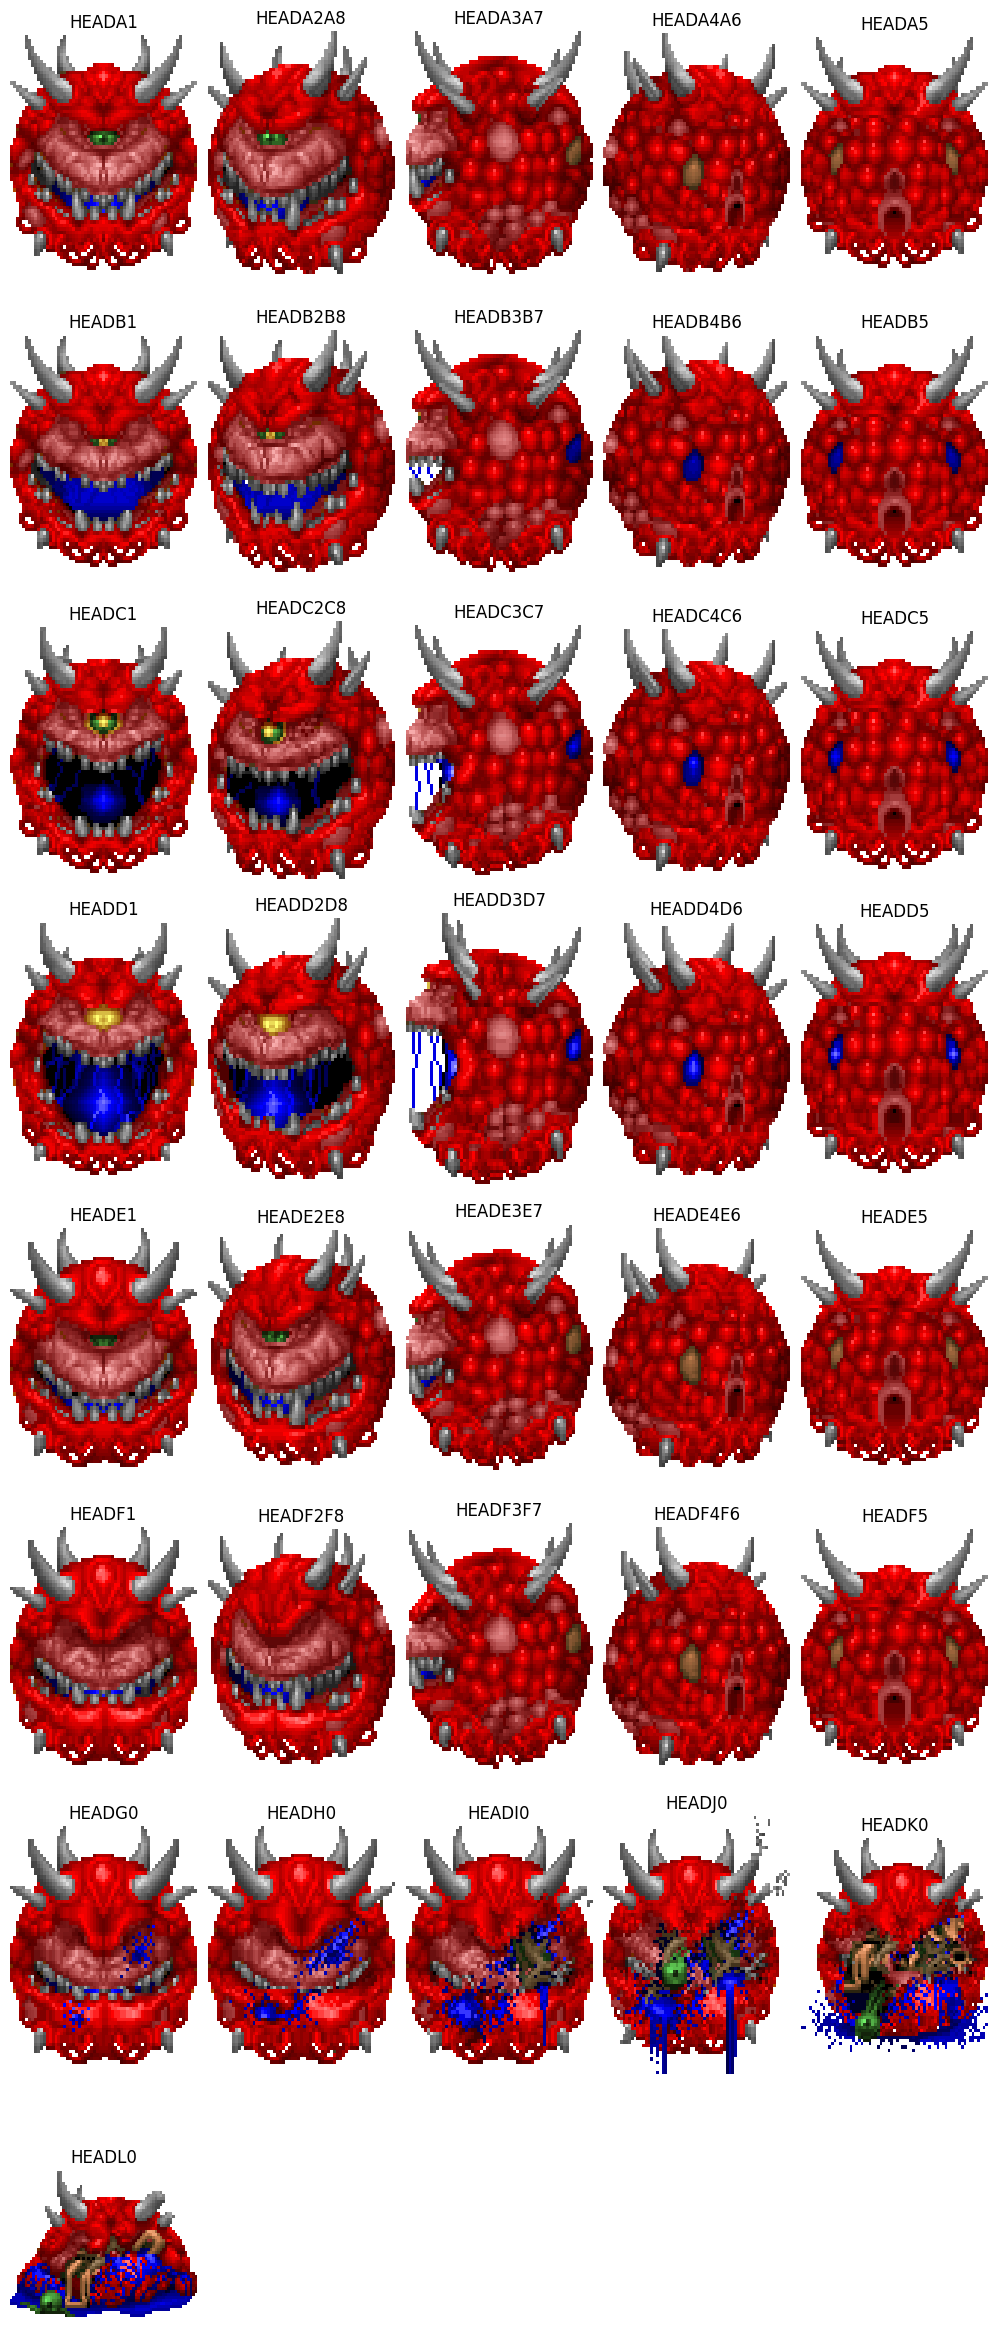

In [7]:
sprite_name = 'HEAD'

sprite_list = w.spritesheets[sprite_name]
ncols=5
nrows = int(np.ceil(len(sprite_list) / ncols))

fig, ax = plt.subplots(ncols=ncols, nrows=nrows, figsize=(10, 3*nrows))
ax = ax.ravel()

for i, (name, offset, size) in enumerate(sprite_list):
    
    rgb_image = w.draw_patch(offset, size)
    ax[i].imshow(rgb_image / 255, aspect=1.2, interpolation='nearest')
    ax[i].set_title(name)
    ax[i].axis('off')

[ax[i].set_visible(False) for i in range(len(sprite_list), len(ax))]
fig.tight_layout(pad=0.8)